In [2]:
%matplotlib inline
from models.yolo_quantized_chScalable import Model, Model_probe
import numpy as np
import matplotlib.pyplot as plt
import torch
from utils.datasets import LoadImagesAndLabels
import yaml
import tqdm
# from sklearn.decomposition import IncrementalPCA, PCA
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Transfer encoder of c8 model into c2 model, including squeeze layers of c8 model -> 4 separate convs of c2 (Stride 2 Convs for lower layers)

In [12]:
load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/modelc8S2mix2_SiLU/CompTrain_l1e-1_L1234/weights/best.pt')
mo_ = load['model']
model = Model_probe('models/custom_models/Scalable/Linear_Comb/D4_res1b/model_c8S2mix2_SiLU/yolo_direct_c8S2mix2full_comp.yaml', nc = 9)
model.load_state_dict(mo_)
model = model.to(device)
model.eval();

load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/modelc8S2mix2_SiLU/CompTrain_l1e-1_L1234/weights/best.pt')
mo_ = load['model']
new_model = Model_probe('models/custom_models/Scalable/Linear_Comb/D4_res1b/model_c2_SiLU/yolo_direct_c2S2x4S1x8full_comp.yaml', nc = 9)
weight_transfer_order = [0,1,2,3,4,5,None,None,None,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
for to_id, from_id in enumerate(weight_transfer_order):
    if from_id is None:
        continue
    new_model.model[to_id].load_state_dict(model.model[from_id].state_dict())
    print('Layer {} loaded from pretrained layer {}'.format(to_id, from_id))

Layer 0 loaded from pretrained layer 0
Layer 1 loaded from pretrained layer 1
Layer 2 loaded from pretrained layer 2
Layer 3 loaded from pretrained layer 3
Layer 4 loaded from pretrained layer 4
Layer 5 loaded from pretrained layer 5
Layer 9 loaded from pretrained layer 9
Layer 10 loaded from pretrained layer 10
Layer 11 loaded from pretrained layer 11
Layer 12 loaded from pretrained layer 12
Layer 13 loaded from pretrained layer 13
Layer 14 loaded from pretrained layer 14
Layer 15 loaded from pretrained layer 15
Layer 16 loaded from pretrained layer 16
Layer 17 loaded from pretrained layer 17
Layer 18 loaded from pretrained layer 18
Layer 19 loaded from pretrained layer 19
Layer 20 loaded from pretrained layer 20
Layer 21 loaded from pretrained layer 21
Layer 22 loaded from pretrained layer 22
Layer 23 loaded from pretrained layer 23
Layer 24 loaded from pretrained layer 24
Layer 25 loaded from pretrained layer 25
Layer 26 loaded from pretrained layer 26
Layer 27 loaded from pretraine

In [14]:
from models.common import Conv_ScalableLinear, ConvInv_ScalableLinear
new_conv = Conv_ScalableLinear(256, [2,2,2,2,2,2,2,2,2,2,2,2], 12, [5,5,5,5,1,1,1,1,1,1,1,1], [2,2,2,2,1,1,1,1,1,1,1,1], None , 1, False, True)
new_invconv = ConvInv_ScalableLinear([2,2,2,2,2,2,2,2,2,2,2,2], 256, 12, [5,5,5,5,1,1,1,1,1,1,1,1], [2,2,2,2,1,1,1,1,1,1,1,1], None , 1, True, True)
print(new_conv)
print(new_invconv)

# from models.common import Conv_ScalableLinear, ConvInv_ScalableLinear
# new_conv = Conv_ScalableLinear(256, [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2], 16, [5,5,5,5,1,1,1,1,1,1,1,1,1,1,1,1], [2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1], None , 1, False, True)
# new_invconv = ConvInv_ScalableLinear([2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2], 256, 16, [5,5,5,5,1,1,1,1,1,1,1,1,1,1,1,1], [2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1], None , 1, True, True)
# print(new_conv)
# print(new_invconv)

Conv_ScalableLinear(
  (CONV): ModuleList(
    (0): Conv2d(256, 2, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): Conv2d(256, 2, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (2): Conv2d(256, 2, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): Conv2d(256, 2, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
    (5): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
    (6): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
    (7): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
    (8): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
    (9): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
    (10): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
    (11): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
  )
  (BN): ModuleList(
    (0): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_run

In [15]:
for i in range(4):
    new_conv.CONV[i].weight = torch.nn.Parameter(model.model[6].CONV[0].weight[2*i:2*i+2,:,:,:])
    new_conv.CONV[i].bias = torch.nn.Parameter(model.model[6].CONV[0].bias[2*i:2*i+2])
    new_conv.BN[i].weight = torch.nn.Parameter(model.model[6].BN[0].weight[2*i:2*i+2])
    new_conv.BN[i].bias = torch.nn.Parameter(model.model[6].BN[0].bias[2*i:2*i+2])
    
for i in range(4,8):
    new_conv.CONV[i].weight = torch.nn.Parameter(model.model[6].CONV[1].weight[2*(i-4):2*(i-4)+2,:,:,:])
    new_conv.CONV[i].bias = torch.nn.Parameter(model.model[6].CONV[1].bias[2*(i-4):2*(i-4)+2])
    new_conv.BN[i].weight = torch.nn.Parameter(model.model[6].BN[1].weight[2*(i-4):2*(i-4)+2])
    new_conv.BN[i].bias = torch.nn.Parameter(model.model[6].BN[1].bias[2*(i-4):2*(i-4)+2])

for i in range(8,12):
    new_conv.CONV[i].weight = torch.nn.Parameter(model.model[6].CONV[2].weight[2*(i-8):2*(i-8)+2,:,:,:])
    new_conv.CONV[i].bias = torch.nn.Parameter(model.model[6].CONV[2].bias[2*(i-8):2*(i-8)+2])
    new_conv.BN[i].weight = torch.nn.Parameter(model.model[6].BN[2].weight[2*(i-8):2*(i-8)+2])
    new_conv.BN[i].bias = torch.nn.Parameter(model.model[6].BN[2].bias[2*(i-8):2*(i-8)+2])
    
# for i in range(12,16):
#     new_conv.CONV[i].weight = torch.nn.Parameter(model.model[6].CONV[3].weight[2*(i-12):2*(i-12)+2,:,:,:])
#     new_conv.CONV[i].bias = torch.nn.Parameter(model.model[6].CONV[3].bias[2*(i-12):2*(i-12)+2])
#     new_conv.BN[i].weight = torch.nn.Parameter(model.model[6].BN[3].weight[2*(i-12):2*(i-12)+2])
#     new_conv.BN[i].bias = torch.nn.Parameter(model.model[6].BN[3].bias[2*(i-12):2*(i-12)+2])

for i in range(4):
    new_invconv.CONV[i].conv.weight = torch.nn.Parameter(model.model[8].CONV[0].conv.weight[2*i:2*i+2,:,:,:])
    # new_invconv.CONV[0].conv.bias = torch.nn.Parameter(model.model[8].CONV[0].conv.bias)
    new_invconv.CONV[i].bn.weight = torch.nn.Parameter(model.model[8].CONV[0].bn.weight)
    new_invconv.CONV[i].bn.bias = torch.nn.Parameter(model.model[8].CONV[0].bn.bias)
    new_invconv.BN[i].weight = torch.nn.Parameter(model.model[8].BN[0].weight)
    new_invconv.BN[i].bias = torch.nn.Parameter(model.model[8].BN[0].bias)

for i in range(4,8):
    new_invconv.CONV[i].weight = torch.nn.Parameter(model.model[8].CONV[1].weight[:,2*(i-4):2*(i-4)+2,:,:])
    new_invconv.CONV[i].bias = torch.nn.Parameter(model.model[8].CONV[1].bias)
    new_invconv.BN[i].weight = torch.nn.Parameter(model.model[8].BN[1].weight)
    new_invconv.BN[i].bias = torch.nn.Parameter(model.model[8].BN[1].bias)
    
for i in range(8,12):
    new_invconv.CONV[i].weight = torch.nn.Parameter(model.model[8].CONV[2].weight[:,2*(i-8):2*(i-8)+2,:,:])
    new_invconv.CONV[i].bias = torch.nn.Parameter(model.model[8].CONV[2].bias)
    new_invconv.BN[i].weight = torch.nn.Parameter(model.model[8].BN[2].weight)
    new_invconv.BN[i].bias = torch.nn.Parameter(model.model[8].BN[2].bias)
    
# for i in range(12,16):
#     new_invconv.CONV[i].weight = torch.nn.Parameter(model.model[8].CONV[3].weight[:,2*(i-12):2*(i-12)+2,:,:])
#     new_invconv.CONV[i].bias = torch.nn.Parameter(model.model[8].CONV[3].bias)
#     new_invconv.BN[i].weight = torch.nn.Parameter(model.model[8].BN[3].weight)
#     new_invconv.BN[i].bias = torch.nn.Parameter(model.model[8].BN[3].bias)

new_model.model[6] = new_conv
new_model.model[8] = new_invconv

In [16]:
ckpt = {'model': new_model.state_dict()}
os.makedirs('runs/Scalable_COCOTraffic/Linear_Comb/modelc8S2mix2_SiLU/EncDecSc_S2c2x4S1c2x8_Transfered_L1234/weights', exist_ok = True)
torch.save(ckpt, 'runs/Scalable_COCOTraffic/Linear_Comb/modelc8S2mix2_SiLU/EncDecSc_S2c2x4S1c2x8_Transfered_L1234/weights/model_weights.pt')

## Decoder 2

In [3]:
load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/modelc8S2mix2_SiLU/CompTrain_l1e-1_L1234/weights/best.pt')
mo_ = load['model']
model = Model_probe('models/custom_models/Scalable/Linear_Comb/D4_res1b/model_c8S2mix2_SiLU/yolo_direct_c8S2mix2full_comp.yaml', nc = 9)
model.load_state_dict(mo_)
model = model.to(device)
model.eval();

load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/modelc8S2mix2_SiLU/CompTrain_l1e-1_L1234/weights/best.pt')
mo_ = load['model']
new_model = Model_probe('models/custom_models/Scalable/Linear_Comb/D4_res1b/model_SplitDecoder/yolo_direct_decoder2.yaml', nc = 9)
weight_transfer_order = [0,1,2,3,4,5,None,None,None,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
for to_id, from_id in enumerate(weight_transfer_order):
    if from_id is None:
        continue
    new_model.model[to_id].load_state_dict(model.model[from_id].state_dict())
    print('Layer {} loaded from pretrained layer {}'.format(to_id, from_id))

Layer 0 loaded from pretrained layer 0
Layer 1 loaded from pretrained layer 1
Layer 2 loaded from pretrained layer 2
Layer 3 loaded from pretrained layer 3
Layer 4 loaded from pretrained layer 4
Layer 5 loaded from pretrained layer 5
Layer 9 loaded from pretrained layer 9
Layer 10 loaded from pretrained layer 10
Layer 11 loaded from pretrained layer 11
Layer 12 loaded from pretrained layer 12
Layer 13 loaded from pretrained layer 13
Layer 14 loaded from pretrained layer 14
Layer 15 loaded from pretrained layer 15
Layer 16 loaded from pretrained layer 16
Layer 17 loaded from pretrained layer 17
Layer 18 loaded from pretrained layer 18
Layer 19 loaded from pretrained layer 19
Layer 20 loaded from pretrained layer 20
Layer 21 loaded from pretrained layer 21
Layer 22 loaded from pretrained layer 22
Layer 23 loaded from pretrained layer 23
Layer 24 loaded from pretrained layer 24
Layer 25 loaded from pretrained layer 25
Layer 26 loaded from pretrained layer 26
Layer 27 loaded from pretraine

In [4]:
from models.common import Conv_ScalableLinear, ConvInv_ScalableLinear
new_conv = Conv_ScalableLinear(256, [8,2,2,2,2], 5, [5,1,1,1,1], [2,1,1,1,1], None , 1, False, True, 1)
new_invconv = ConvInv_ScalableLinear([8,2,2,2,2], 256, 5, [5,1,1,1,1], [2,1,1,1,1], None , 1, True, True, 1)
print(new_conv)
print(new_invconv)

Conv_ScalableLinear(
  (CONV): ModuleList(
    (0): Conv2d(256, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
    (3): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
    (4): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
  )
  (BN): ModuleList(
    (0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (act): Identity()
)
ConvInv_ScalableLinear(
  (CONV): ModuleList(
    (0): TransposeConv(
      (conv): ConvTranspose2d(8, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2

In [10]:
new_conv.CONV[0].load_state_dict(model.model[6].CONV[0].state_dict())
new_conv.BN[0].load_state_dict(model.model[6].BN[0].state_dict())

new_invconv.CONV[0].load_state_dict(model.model[8].CONV[0].state_dict())
new_invconv.BN[0].load_state_dict(model.model[8].BN[0].state_dict())
    
for i in range(4):
    new_conv.CONV[i+1].weight = torch.nn.Parameter(model.model[6].CONV[1].weight[2*i:2*i+2,:,:,:])
    new_conv.CONV[i+1].bias = torch.nn.Parameter(model.model[6].CONV[1].bias[2*i:2*i+2])
    new_conv.BN[i+1].weight = torch.nn.Parameter(model.model[6].BN[1].weight[2*i:2*i+2])
    new_conv.BN[i+1].bias = torch.nn.Parameter(model.model[6].BN[1].bias[2*i:2*i+2])

for i in range(4):
    new_invconv.CONV[i+1].weight = torch.nn.Parameter(model.model[8].CONV[1].weight[:,2*i:2*i+2,:,:])
    new_invconv.CONV[i+1].bias = torch.nn.Parameter(model.model[8].CONV[1].bias)
    new_invconv.BN[i+1].weight = torch.nn.Parameter(model.model[8].BN[1].weight)
    new_invconv.BN[i+1].bias = torch.nn.Parameter(model.model[8].BN[1].bias)


new_model.model[6] = new_conv
new_model.model[8] = new_invconv

new_model.model[7].Comp[0].load_state_dict(model.model[7].Comp[0].state_dict())

In [11]:
ckpt = {'model': new_model.state_dict()}
os.makedirs('runs/Scalable_COCOTraffic/Linear_Comb/modelc8S2mix2_SiLU/Dec2_S1c2x4_Transfered/weights', exist_ok = True)
torch.save(ckpt, 'runs/Scalable_COCOTraffic/Linear_Comb/modelc8S2mix2_SiLU/Dec2_S1c2x4_Transfered/weights/model_weights.pt')

## Decoder 2 with lower rate decoder as initial

In [11]:
load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/model_c8S2mix2_SiLU/EncScFreeze_c1x8_L1234_l1e-1_L1111/weights/best.pt')
mo_ = load['model']
model_low = Model_probe('models/custom_models/Scalable/Linear_Comb/D4_res1b/model_c1_SiLU/yolo_direct_c1S2x8full_comp.yaml', nc = 9)
model_low.load_state_dict(mo_)
model_low = model_low.to(device)
model_low.eval();

load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/modelc8S2mix2_SiLU/CompTrain_l1e-1_L1234/weights/best.pt')
mo_ = load['model']
model_high = Model_probe('models/custom_models/Scalable/Linear_Comb/D4_res1b/model_c8S2mix2_SiLU/yolo_direct_c8S2mix2full_comp.yaml', nc = 9)
model_high.load_state_dict(mo_)
model_high = model_high.to(device)
model_high.eval();

new_model = Model_probe('models/custom_models/Scalable/Linear_Comb/D4_res1b/model_SplitDecoder/yolo_direct_decoder2_decLow.yaml', nc = 9)
weight_transfer_order = [0,1,2,3,4,5,None,None,None,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
for to_id, from_id in enumerate(weight_transfer_order):
    if from_id is None:
        continue
    new_model.model[to_id].load_state_dict(model_low.model[from_id].state_dict())
    print('Layer {} loaded from pretrained layer {}'.format(to_id, from_id))

Layer 0 loaded from pretrained layer 0
Layer 1 loaded from pretrained layer 1
Layer 2 loaded from pretrained layer 2
Layer 3 loaded from pretrained layer 3
Layer 4 loaded from pretrained layer 4
Layer 5 loaded from pretrained layer 5
Layer 9 loaded from pretrained layer 9
Layer 10 loaded from pretrained layer 10
Layer 11 loaded from pretrained layer 11
Layer 12 loaded from pretrained layer 12
Layer 13 loaded from pretrained layer 13
Layer 14 loaded from pretrained layer 14
Layer 15 loaded from pretrained layer 15
Layer 16 loaded from pretrained layer 16
Layer 17 loaded from pretrained layer 17
Layer 18 loaded from pretrained layer 18
Layer 19 loaded from pretrained layer 19
Layer 20 loaded from pretrained layer 20
Layer 21 loaded from pretrained layer 21
Layer 22 loaded from pretrained layer 22
Layer 23 loaded from pretrained layer 23
Layer 24 loaded from pretrained layer 24
Layer 25 loaded from pretrained layer 25
Layer 26 loaded from pretrained layer 26
Layer 27 loaded from pretraine

In [12]:
from models.common import Conv_ScalableLinear, ConvInv_ScalableLinear
new_conv = Conv_ScalableLinear(256, [1,1,1,1,1,1,1,1,2,2,2,2], 12, [5,5,5,5,5,5,5,5,1,1,1,1], [2,2,2,2,2,2,2,2,1,1,1,1], None , 1, False, True, 8)
new_invconv = ConvInv_ScalableLinear([1,1,1,1,1,1,1,1,2,2,2,2], 256, 12, [5,5,5,5,5,5,5,5,1,1,1,1], [2,2,2,2,2,2,2,2,1,1,1,1], None , 1, True, True, 8)

In [13]:
for i in range(8):
    new_conv.CONV[i].load_state_dict(model_low.model[6].CONV[i].state_dict())
    new_conv.BN[i].load_state_dict(model_low.model[6].BN[i].state_dict())

for i in range(8):
    new_invconv.CONV[i].load_state_dict(model_low.model[8].CONV[i].state_dict())
    new_invconv.BN[i].load_state_dict(model_low.model[8].BN[i].state_dict())
    
for i in range(4):
    new_conv.CONV[i+8].weight = torch.nn.Parameter(model_high.model[6].CONV[1].weight[2*i:2*i+2,:,:,:])
    new_conv.CONV[i+8].bias = torch.nn.Parameter(model_high.model[6].CONV[1].bias[2*i:2*i+2])
    new_conv.BN[i+8].weight = torch.nn.Parameter(model_high.model[6].BN[1].weight[2*i:2*i+2])
    new_conv.BN[i+8].bias = torch.nn.Parameter(model_high.model[6].BN[1].bias[2*i:2*i+2])

for i in range(4):
    new_invconv.CONV[i+8].weight = torch.nn.Parameter(model_high.model[8].CONV[1].weight[:,2*i:2*i+2,:,:])
    new_invconv.CONV[i+8].bias = torch.nn.Parameter(model_high.model[8].CONV[1].bias)
    new_invconv.BN[i+8].weight = torch.nn.Parameter(model_high.model[8].BN[1].weight)
    new_invconv.BN[i+8].bias = torch.nn.Parameter(model_high.model[8].BN[1].bias)


new_model.model[6] = new_conv
new_model.model[8] = new_invconv

for i in range(8):
    new_model.model[7].Comp[i].load_state_dict(model_low.model[7].Comp[i].state_dict())

In [14]:
ckpt = {'model': new_model.state_dict()}
os.makedirs('runs/Scalable_COCOTraffic/Linear_Comb/modelc8S2mix2_SiLU/Dec2_S1c2x4_Transfered_decLow/weights', exist_ok = True)
torch.save(ckpt, 'runs/Scalable_COCOTraffic/Linear_Comb/modelc8S2mix2_SiLU/Dec2_S1c2x4_Transfered_decLow/weights/model_weights.pt')

## Decoder 3

In [14]:
load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/modelc8S2mix2_SiLU/CompTrain_l1e-1_L1234/weights/best.pt')
mo_ = load['model']
model = Model_probe('models/custom_models/Scalable/Linear_Comb/D4_res1b/model_c8S2mix2_SiLU/yolo_direct_c8S2mix2full_comp.yaml', nc = 9)
model.load_state_dict(mo_)
model = model.to(device)
model.eval();

load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/modelc8S2mix2_SiLU/CompTrain_l1e-1_L1234/weights/best.pt')
mo_ = load['model']
new_model = Model_probe('models/custom_models/Scalable/Linear_Comb/D4_res1b/model_SplitDecoder/yolo_direct_decoder3.yaml', nc = 9)
weight_transfer_order = [0,1,2,3,4,5,None,None,None,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
for to_id, from_id in enumerate(weight_transfer_order):
    if from_id is None:
        continue
    new_model.model[to_id].load_state_dict(model.model[from_id].state_dict())
    print('Layer {} loaded from pretrained layer {}'.format(to_id, from_id))

Layer 0 loaded from pretrained layer 0
Layer 1 loaded from pretrained layer 1
Layer 2 loaded from pretrained layer 2
Layer 3 loaded from pretrained layer 3
Layer 4 loaded from pretrained layer 4
Layer 5 loaded from pretrained layer 5
Layer 9 loaded from pretrained layer 9
Layer 10 loaded from pretrained layer 10
Layer 11 loaded from pretrained layer 11
Layer 12 loaded from pretrained layer 12
Layer 13 loaded from pretrained layer 13
Layer 14 loaded from pretrained layer 14
Layer 15 loaded from pretrained layer 15
Layer 16 loaded from pretrained layer 16
Layer 17 loaded from pretrained layer 17
Layer 18 loaded from pretrained layer 18
Layer 19 loaded from pretrained layer 19
Layer 20 loaded from pretrained layer 20
Layer 21 loaded from pretrained layer 21
Layer 22 loaded from pretrained layer 22
Layer 23 loaded from pretrained layer 23
Layer 24 loaded from pretrained layer 24
Layer 25 loaded from pretrained layer 25
Layer 26 loaded from pretrained layer 26
Layer 27 loaded from pretraine

In [15]:
from models.common import Conv_ScalableLinear, ConvInv_ScalableLinear
new_conv = Conv_ScalableLinear(256, [8,8,2,2,2,2], 5, [5,1,1,1,1,1], [2,1,1,1,1,1], None , 1, False, True, 1)
new_invconv = ConvInv_ScalableLinear([8,8,2,2,2,2], 256, 5, [5,1,1,1,1,1], [2,1,1,1,1,1], None , 1, True, True, 1)
print(new_conv)
print(new_invconv)

Conv_ScalableLinear(
  (CONV): ModuleList(
    (0): Conv2d(256, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): Conv2d(256, 8, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
    (3): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
    (4): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
    (5): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
  )
  (BN): ModuleList(
    (0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (act): Identity()
)
ConvInv_S

In [16]:
new_conv.CONV[0].load_state_dict(model.model[6].CONV[0].state_dict())
new_conv.BN[0].load_state_dict(model.model[6].BN[0].state_dict())
new_conv.CONV[1].load_state_dict(model.model[6].CONV[1].state_dict())
new_conv.BN[1].load_state_dict(model.model[6].BN[1].state_dict())

new_invconv.CONV[0].load_state_dict(model.model[8].CONV[0].state_dict())
new_invconv.BN[0].load_state_dict(model.model[8].BN[0].state_dict())
new_invconv.CONV[1].load_state_dict(model.model[8].CONV[1].state_dict())
new_invconv.BN[1].load_state_dict(model.model[8].BN[1].state_dict())
    
for i in range(4):
    new_conv.CONV[i+2].weight = torch.nn.Parameter(model.model[6].CONV[2].weight[2*i:2*i+2,:,:,:])
    new_conv.CONV[i+2].bias = torch.nn.Parameter(model.model[6].CONV[2].bias[2*i:2*i+2])
    new_conv.BN[i+2].weight = torch.nn.Parameter(model.model[6].BN[2].weight[2*i:2*i+2])
    new_conv.BN[i+2].bias = torch.nn.Parameter(model.model[6].BN[2].bias[2*i:2*i+2])

for i in range(4):
    new_invconv.CONV[i+2].weight = torch.nn.Parameter(model.model[8].CONV[2].weight[:,2*i:2*i+2,:,:])
    new_invconv.CONV[i+2].bias = torch.nn.Parameter(model.model[8].CONV[2].bias)
    new_invconv.BN[i+2].weight = torch.nn.Parameter(model.model[8].BN[2].weight)
    new_invconv.BN[i+2].bias = torch.nn.Parameter(model.model[8].BN[2].bias)


new_model.model[6] = new_conv
new_model.model[8] = new_invconv

new_model.model[7].Comp[0].load_state_dict(model.model[7].Comp[0].state_dict())
new_model.model[7].Comp[1].load_state_dict(model.model[7].Comp[1].state_dict())

In [17]:
ckpt = {'model': new_model.state_dict()}
os.makedirs('runs/Scalable_COCOTraffic/Linear_Comb/modelc8S2mix2_SiLU/Dec3_S1c2x4_Transfered/weights', exist_ok = True)
torch.save(ckpt, 'runs/Scalable_COCOTraffic/Linear_Comb/modelc8S2mix2_SiLU/Dec3_S1c2x4_Transfered/weights/model_weights.pt')

# Rerun RCLWN models

In [7]:
load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Original_models/CompTrain_l1e-1_L1234/weights/best.pt')
mo_ = load['model']
model = Model_probe('models/custom_models/Scalable/Linear_Comb/RCLWN_model/yolo_direct_c8S2mix2full_comp.yaml', nc = 9)
model.load_state_dict(mo_)
model = model.to(device)
model.eval();

load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Original_models/CompTrain_l1e-1_L1234/weights/best.pt')
mo_ = load['model']
new_model = Model_probe('models/custom_models/Scalable/Linear_Comb/RCLWN_model/yolo_direct_c1S2x8full_comp.yaml', nc = 9)
weight_transfer_order = [0,1,2,3,4,5,None,None,None,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
for to_id, from_id in enumerate(weight_transfer_order):
    if from_id is None:
        continue
    new_model.model[to_id].load_state_dict(model.model[from_id].state_dict())
    print('Layer {} loaded from pretrained layer {}'.format(to_id, from_id))

Layer 0 loaded from pretrained layer 0
Layer 1 loaded from pretrained layer 1
Layer 2 loaded from pretrained layer 2
Layer 3 loaded from pretrained layer 3
Layer 4 loaded from pretrained layer 4
Layer 5 loaded from pretrained layer 5
Layer 9 loaded from pretrained layer 9
Layer 10 loaded from pretrained layer 10
Layer 11 loaded from pretrained layer 11
Layer 12 loaded from pretrained layer 12
Layer 13 loaded from pretrained layer 13
Layer 14 loaded from pretrained layer 14
Layer 15 loaded from pretrained layer 15
Layer 16 loaded from pretrained layer 16
Layer 17 loaded from pretrained layer 17
Layer 18 loaded from pretrained layer 18
Layer 19 loaded from pretrained layer 19
Layer 20 loaded from pretrained layer 20
Layer 21 loaded from pretrained layer 21
Layer 22 loaded from pretrained layer 22
Layer 23 loaded from pretrained layer 23
Layer 24 loaded from pretrained layer 24
Layer 25 loaded from pretrained layer 25
Layer 26 loaded from pretrained layer 26
Layer 27 loaded from pretraine

In [8]:
from models.common import Conv_ScalableLinear, ConvInv_ScalableLinear
new_conv = Conv_ScalableLinear(256, [1,1,1,1,1,1,1,1], 8, [5,5,5,5,5,5,5,5], [2,2,2,2,2,2,2,2], None , 1, False, True)
new_invconv = ConvInv_ScalableLinear([1,1,1,1,1,1,1,1], 256, 8, [5,5,5,5,5,5,5,5], [2,2,2,2,2,2,2,2], None , 1, True, True)
print(model.model[6].CONV[0])
print(model.model[6])

Conv2d(256, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
Conv_ScalableLinear(
  (CONV): ModuleList(
    (0): Conv2d(256, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): Conv2d(256, 8, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(256, 8, kernel_size=(1, 1), stride=(1, 1))
    (3): Conv2d(256, 8, kernel_size=(1, 1), stride=(1, 1))
  )
  (BN): ModuleList(
    (0): BatchNorm2d(8, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (1): BatchNorm2d(8, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (2): BatchNorm2d(8, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (3): BatchNorm2d(8, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  )
  (act): Identity()
)


In [9]:
for i in range(8):
    new_conv.CONV[i].weight = torch.nn.Parameter(model.model[6].CONV[0].weight[i:i+1,:,:,:])
    new_conv.CONV[i].bias = torch.nn.Parameter(model.model[6].CONV[0].bias[i:i+1])
    new_conv.BN[i].weight = torch.nn.Parameter(model.model[6].BN[0].weight[i:i+1])
    new_conv.BN[i].bias = torch.nn.Parameter(model.model[6].BN[0].bias[i:i+1])

for i in range(8):
    new_invconv.CONV[i].conv.weight = torch.nn.Parameter(model.model[8].CONV[0].conv.weight[i:i+1,:,:,:])
    new_invconv.CONV[i].bn.weight = torch.nn.Parameter(model.model[8].CONV[0].bn.weight)
    new_invconv.CONV[i].bn.bias = torch.nn.Parameter(model.model[8].CONV[0].bn.bias)
    new_invconv.BN[i].weight = torch.nn.Parameter(model.model[8].BN[0].weight)
    new_invconv.BN[i].bias = torch.nn.Parameter(model.model[8].BN[0].bias)

new_model.model[6] = new_conv
new_model.model[8] = new_invconv

In [10]:
ckpt = {'model': new_model.state_dict()}
os.makedirs('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/EncDecSc_Transfered_c1x8_L1234/weights', exist_ok = True)
torch.save(ckpt, 'runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/EncDecSc_Transfered_c1x8_L1234/weights/model_weights.pt')

## Load trained model into separate encoder and decoder

In [2]:
load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/EncScExFreeze_c1x8_L1234_l1e-1_L1111/weights/best.pt')
mo_ = load['model']
model_lowRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/yolo_direct_c1S2x8full_comp.yaml', nc = 9)
model_lowRate.load_state_dict(mo_)
model_lowRate = model_lowRate.to(device)
model_lowRate.eval();

load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Original_models/CompTrain_l1e-1_L1234/weights/best.pt')
mo_ = load['model']
model_highRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/yolo_direct_c8S2mix2full_comp.yaml', nc = 9)
model_highRate.load_state_dict(mo_)
model_highRate = model_highRate.to(device)
model_highRate.eval();

new_model_enc = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/Multiple_decoders/yolo_direct_c1S2x8full_comp_encoder.yaml', nc = 9)
weight_transfer_order = [0,1,2,3,4,5,None,None,None]
for to_id, from_id in enumerate(weight_transfer_order):
    if from_id is None:
        continue
    new_model_enc.model[to_id].load_state_dict(model_lowRate.model[from_id].state_dict())
    print('Layer {} loaded from pretrained layer {}'.format(to_id, from_id))

Layer 0 loaded from pretrained layer 0
Layer 1 loaded from pretrained layer 1
Layer 2 loaded from pretrained layer 2
Layer 3 loaded from pretrained layer 3
Layer 4 loaded from pretrained layer 4
Layer 5 loaded from pretrained layer 5


In [3]:
for i in range(8):
    new_model_enc.model[6].CONV[i].load_state_dict(model_lowRate.model[6].CONV[i].state_dict())
    new_model_enc.model[6].BN[i].load_state_dict(model_lowRate.model[6].BN[i].state_dict())
    new_model_enc.model[7].Comp[i].load_state_dict(model_lowRate.model[7].Comp[i].state_dict())
    new_model_enc.model[8].CONV[i].load_state_dict(model_lowRate.model[8].CONV[i].state_dict())
    new_model_enc.model[8].BN[i].load_state_dict(model_lowRate.model[8].BN[i].state_dict())
    
    
for i in range(3):
    new_model_enc.model[6].CONV[i+8].load_state_dict(model_highRate.model[6].CONV[i+1].state_dict())
    new_model_enc.model[6].BN[i+8].load_state_dict(model_highRate.model[6].BN[i+1].state_dict())
    new_model_enc.model[7].Comp[i+8].load_state_dict(model_highRate.model[7].Comp[i+1].state_dict())
    new_model_enc.model[8].CONV[i+8].load_state_dict(model_highRate.model[8].CONV[i+1].state_dict())
    new_model_enc.model[8].BN[i+8].load_state_dict(model_highRate.model[8].BN[i+1].state_dict())

In [4]:
ckpt = {'model': new_model_enc.state_dict()}
os.makedirs('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Multiple_decoders_simul/Enc_init/weights', exist_ok = True)
torch.save(ckpt, 'runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Multiple_decoders_simul/Enc_init/weights/model_weights.pt')

In [5]:
load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Original_models/CompTrain_l1e-1_L1234/weights/best.pt')
mo_ = load['model']
model_highRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/yolo_direct_c8S2mix2full_comp.yaml', nc = 9)
model_highRate.load_state_dict(mo_)
model_highRate = model_highRate.to(device)
model_highRate.eval();

new_model_dec_highRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/Multiple_decoders/yolo_direct_c1S2x8full_comp_decoder.yaml', nc = 9)
weight_transfer_order = [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
for to_id, from_id in enumerate(weight_transfer_order):
    if from_id is None:
        continue
    new_model_dec_highRate.model[to_id].load_state_dict(model_highRate.model[from_id].state_dict())
    print('Layer {} loaded from pretrained layer {}'.format(to_id, from_id))

Layer 0 loaded from pretrained layer 9
Layer 1 loaded from pretrained layer 10
Layer 2 loaded from pretrained layer 11
Layer 3 loaded from pretrained layer 12
Layer 4 loaded from pretrained layer 13
Layer 5 loaded from pretrained layer 14
Layer 6 loaded from pretrained layer 15
Layer 7 loaded from pretrained layer 16
Layer 8 loaded from pretrained layer 17
Layer 9 loaded from pretrained layer 18
Layer 10 loaded from pretrained layer 19
Layer 11 loaded from pretrained layer 20
Layer 12 loaded from pretrained layer 21
Layer 13 loaded from pretrained layer 22
Layer 14 loaded from pretrained layer 23
Layer 15 loaded from pretrained layer 24
Layer 16 loaded from pretrained layer 25
Layer 17 loaded from pretrained layer 26
Layer 18 loaded from pretrained layer 27


/ext3/miniconda3/envs/torch_env/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643004612/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
ckpt = {'model': new_model_dec_highRate.state_dict()}
os.makedirs('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Multiple_decoders_simul/Dec_init_highRate/weights', exist_ok = True)
torch.save(ckpt, 'runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Multiple_decoders_simul/Dec_init_highRate/weights/model_weights.pt')

In [7]:
load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/EncScExFreeze_c1x8_L1234_l1e-1_L1111/weights/best.pt')
mo_ = load['model']
model_lowRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/yolo_direct_c1S2x8full_comp.yaml', nc = 9)
model_lowRate.load_state_dict(mo_)
model_lowRate = model_lowRate.to(device)
model_lowRate.eval();

new_model_dec_lowRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/Multiple_decoders/yolo_direct_c1S2x8full_comp_decoder.yaml', nc = 9)
weight_transfer_order = [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
for to_id, from_id in enumerate(weight_transfer_order):
    if from_id is None:
        continue
    new_model_dec_lowRate.model[to_id].load_state_dict(model_lowRate.model[from_id].state_dict())
    print('Layer {} loaded from pretrained layer {}'.format(to_id, from_id))

Layer 0 loaded from pretrained layer 9
Layer 1 loaded from pretrained layer 10
Layer 2 loaded from pretrained layer 11
Layer 3 loaded from pretrained layer 12
Layer 4 loaded from pretrained layer 13
Layer 5 loaded from pretrained layer 14
Layer 6 loaded from pretrained layer 15
Layer 7 loaded from pretrained layer 16
Layer 8 loaded from pretrained layer 17
Layer 9 loaded from pretrained layer 18
Layer 10 loaded from pretrained layer 19
Layer 11 loaded from pretrained layer 20
Layer 12 loaded from pretrained layer 21
Layer 13 loaded from pretrained layer 22
Layer 14 loaded from pretrained layer 23
Layer 15 loaded from pretrained layer 24
Layer 16 loaded from pretrained layer 25
Layer 17 loaded from pretrained layer 26
Layer 18 loaded from pretrained layer 27


In [9]:
ckpt = {'model': new_model_dec_lowRate.state_dict()}
os.makedirs('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Multiple_decoders_simul/Dec_init_lowRate/weights', exist_ok = True)
torch.save(ckpt, 'runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Multiple_decoders_simul/Dec_init_lowRate/weights/model_weights.pt')

In [10]:
ckpt = {'model_enc': new_model_enc.state_dict(),
       'model_dec_low': new_model_dec_lowRate.state_dict(),
       'model_dec_high': new_model_dec_highRate.state_dict()}

os.makedirs('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Multiple_decoders_simul/Dec_init_lowRate/weights', exist_ok = True)
torch.save(ckpt, 'runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Multiple_decoders_simul/Dec_init_lowRate/weights/model_weights_combined.pt')
del ckpt
del new_model_enc
del new_model_dec_highRate
del new_model_dec_lowRate
del model_highRate
del model_lowRate

## Directly Simul train lower and higher decoders, init from high encoder and decoder model

In [7]:
load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Original_models/CompTrain_l1e-1_L1234/weights/best.pt')
mo_ = load['model']
model_lowRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/yolo_direct_c8S2mix2full_comp.yaml', nc = 9)
model_lowRate.load_state_dict(mo_)
model_lowRate = model_lowRate.to(device)
model_lowRate.eval();

load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Original_models/CompTrain_l1e-1_L1234/weights/best.pt')
mo_ = load['model']
model_highRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/yolo_direct_c8S2mix2full_comp.yaml', nc = 9)
model_highRate.load_state_dict(mo_)
model_highRate = model_highRate.to(device)
model_highRate.eval();

new_model_enc = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/Multiple_decoders/yolo_direct_c1S2x8full_comp_encoder.yaml', nc = 9)
weight_transfer_order = [0,1,2,3,4,5,None,None,None]
for to_id, from_id in enumerate(weight_transfer_order):
    if from_id is None:
        continue
    new_model_enc.model[to_id].load_state_dict(model_lowRate.model[from_id].state_dict())
    print('Layer {} loaded from pretrained layer {}'.format(to_id, from_id))

Layer 0 loaded from pretrained layer 0
Layer 1 loaded from pretrained layer 1
Layer 2 loaded from pretrained layer 2
Layer 3 loaded from pretrained layer 3
Layer 4 loaded from pretrained layer 4
Layer 5 loaded from pretrained layer 5


In [8]:
for i in range(8):
    new_model_enc.model[6].CONV[i].weight = torch.nn.Parameter(model_lowRate.model[6].CONV[0].weight[i:i+1,:,:,:])
    new_model_enc.model[6].CONV[i].bias = torch.nn.Parameter(model_lowRate.model[6].CONV[0].bias[i:i+1])
    new_model_enc.model[6].BN[i].weight = torch.nn.Parameter(model_lowRate.model[6].BN[0].weight[i:i+1])
    new_model_enc.model[6].BN[i].bias = torch.nn.Parameter(model_lowRate.model[6].BN[0].bias[i:i+1])

for i in range(8):
    new_model_enc.model[8].CONV[i].conv.weight = torch.nn.Parameter(model_lowRate.model[8].CONV[0].conv.weight[i:i+1,:,:,:])
    new_model_enc.model[8].CONV[i].bn.weight = torch.nn.Parameter(model_lowRate.model[8].CONV[0].bn.weight)
    new_model_enc.model[8].CONV[i].bn.bias = torch.nn.Parameter(model_lowRate.model[8].CONV[0].bn.bias)
    new_model_enc.model[8].BN[i].weight = torch.nn.Parameter(model_lowRate.model[8].BN[0].weight)
    new_model_enc.model[8].BN[i].bias = torch.nn.Parameter(model_lowRate.model[8].BN[0].bias)
    
for i in range(3):
    new_model_enc.model[6].CONV[i+8].load_state_dict(model_highRate.model[6].CONV[i+1].state_dict())
    new_model_enc.model[6].BN[i+8].load_state_dict(model_highRate.model[6].BN[i+1].state_dict())
    new_model_enc.model[7].Comp[i+8].load_state_dict(model_highRate.model[7].Comp[i+1].state_dict())
    new_model_enc.model[8].CONV[i+8].load_state_dict(model_highRate.model[8].CONV[i+1].state_dict())
    new_model_enc.model[8].BN[i+8].load_state_dict(model_highRate.model[8].BN[i+1].state_dict())

In [10]:
new_model_dec_highRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/Multiple_decoders/yolo_direct_c1S2x8full_comp_decoder.yaml', nc = 9)
weight_transfer_order = [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
for to_id, from_id in enumerate(weight_transfer_order):
    if from_id is None:
        continue
    new_model_dec_highRate.model[to_id].load_state_dict(model_highRate.model[from_id].state_dict())
    print('Layer {} loaded from pretrained layer {}'.format(to_id, from_id))
    
new_model_dec_lowRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/Multiple_decoders/yolo_direct_c1S2x8full_comp_decoder.yaml', nc = 9)
weight_transfer_order = [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
for to_id, from_id in enumerate(weight_transfer_order):
    if from_id is None:
        continue
    new_model_dec_lowRate.model[to_id].load_state_dict(model_lowRate.model[from_id].state_dict())
    print('Layer {} loaded from pretrained layer {}'.format(to_id, from_id))

/ext3/miniconda3/envs/torch_env/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643004612/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Layer 0 loaded from pretrained layer 9
Layer 1 loaded from pretrained layer 10
Layer 2 loaded from pretrained layer 11
Layer 3 loaded from pretrained layer 12
Layer 4 loaded from pretrained layer 13
Layer 5 loaded from pretrained layer 14
Layer 6 loaded from pretrained layer 15
Layer 7 loaded from pretrained layer 16
Layer 8 loaded from pretrained layer 17
Layer 9 loaded from pretrained layer 18
Layer 10 loaded from pretrained layer 19
Layer 11 loaded from pretrained layer 20
Layer 12 loaded from pretrained layer 21
Layer 13 loaded from pretrained layer 22
Layer 14 loaded from pretrained layer 23
Layer 15 loaded from pretrained layer 24
Layer 16 loaded from pretrained layer 25
Layer 17 loaded from pretrained layer 26
Layer 18 loaded from pretrained layer 27
Layer 0 loaded from pretrained layer 9
Layer 1 loaded from pretrained layer 10
Layer 2 loaded from pretrained layer 11
Layer 3 loaded from pretrained layer 12
Layer 4 loaded from pretrained layer 13
Layer 5 loaded from pretrained la

In [11]:
ckpt = {'model_enc': new_model_enc.state_dict(),
       'model_dec_low': new_model_dec_lowRate.state_dict(),
       'model_dec_high': new_model_dec_highRate.state_dict()}

os.makedirs('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Multiple_decoders_simul/EncDec_initFromOrig/weights', exist_ok = True)
torch.save(ckpt, 'runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Multiple_decoders_simul/EncDec_initFromOrig/weights/model_weights_combined.pt')

### c1S2x8c2x4full_comp_encoder

In [4]:
load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Original_models/CompTrain_l1e-1_L1234/weights/best.pt',map_location=torch.device('cpu'))
mo_ = load['model']
model_lowRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/yolo_direct_c8S2mix2full_comp.yaml', nc = 9)
model_lowRate.load_state_dict(mo_)
model_lowRate = model_lowRate.to(device)
model_lowRate.eval();

load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Original_models/CompTrain_l1e-1_L1234/weights/best.pt',map_location=torch.device('cpu'))
mo_ = load['model']
model_highRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/yolo_direct_c8S2mix2full_comp.yaml', nc = 9)
model_highRate.load_state_dict(mo_)
model_highRate = model_highRate.to(device)
model_highRate.eval();

new_model_enc = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/Multiple_decoders/yolo_direct_c1S2x8c2x4full_comp_encoder.yaml', nc = 9)
weight_transfer_order = [0,1,2,3,4,5,None,None,None]
for to_id, from_id in enumerate(weight_transfer_order):
    if from_id is None:
        continue
    new_model_enc.model[to_id].load_state_dict(model_lowRate.model[from_id].state_dict())
    print('Layer {} loaded from pretrained layer {}'.format(to_id, from_id))

Layer 0 loaded from pretrained layer 0
Layer 1 loaded from pretrained layer 1
Layer 2 loaded from pretrained layer 2
Layer 3 loaded from pretrained layer 3
Layer 4 loaded from pretrained layer 4
Layer 5 loaded from pretrained layer 5


In [5]:
for i in range(8):
    new_model_enc.model[6].CONV[i].weight = torch.nn.Parameter(model_lowRate.model[6].CONV[0].weight[i:i+1,:,:,:])
    new_model_enc.model[6].CONV[i].bias = torch.nn.Parameter(model_lowRate.model[6].CONV[0].bias[i:i+1])
    new_model_enc.model[6].BN[i].weight = torch.nn.Parameter(model_lowRate.model[6].BN[0].weight[i:i+1])
    new_model_enc.model[6].BN[i].bias = torch.nn.Parameter(model_lowRate.model[6].BN[0].bias[i:i+1])
    
for i in range(4):
    new_model_enc.model[6].CONV[i+8].weight = torch.nn.Parameter(model_lowRate.model[6].CONV[1].weight[2*i:2*i+2,:,:,:])
    new_model_enc.model[6].CONV[i+8].bias = torch.nn.Parameter(model_lowRate.model[6].CONV[1].bias[2*i:2*i+2])
    new_model_enc.model[6].BN[i+8].weight = torch.nn.Parameter(model_lowRate.model[6].BN[1].weight[2*i:2*i+2])
    new_model_enc.model[6].BN[i+8].bias = torch.nn.Parameter(model_lowRate.model[6].BN[1].bias[2*i:2*i+2])

for i in range(8):
    new_model_enc.model[8].CONV[i].conv.weight = torch.nn.Parameter(model_lowRate.model[8].CONV[0].conv.weight[i:i+1,:,:,:])
    new_model_enc.model[8].CONV[i].bn.weight = torch.nn.Parameter(model_lowRate.model[8].CONV[0].bn.weight)
    new_model_enc.model[8].CONV[i].bn.bias = torch.nn.Parameter(model_lowRate.model[8].CONV[0].bn.bias)
    new_model_enc.model[8].BN[i].weight = torch.nn.Parameter(model_lowRate.model[8].BN[0].weight)
    new_model_enc.model[8].BN[i].bias = torch.nn.Parameter(model_lowRate.model[8].BN[0].bias)

for i in range(4):
    new_model_enc.model[8].CONV[i+8].weight = torch.nn.Parameter(model_lowRate.model[8].CONV[1].weight[:,2*i:2*i+2,:,:])
    new_model_enc.model[8].CONV[i+8].bias = torch.nn.Parameter(model_lowRate.model[8].CONV[1].bias)
    new_model_enc.model[8].BN[i+8].weight = torch.nn.Parameter(model_lowRate.model[8].BN[1].weight)
    new_model_enc.model[8].BN[i+8].bias = torch.nn.Parameter(model_lowRate.model[8].BN[1].bias)
    
for i in range(2):
    new_model_enc.model[6].CONV[i+12].load_state_dict(model_highRate.model[6].CONV[i+2].state_dict())
    new_model_enc.model[6].BN[i+12].load_state_dict(model_highRate.model[6].BN[i+2].state_dict())
    new_model_enc.model[7].Comp[i+12].load_state_dict(model_highRate.model[7].Comp[i+2].state_dict())
    new_model_enc.model[8].CONV[i+12].load_state_dict(model_highRate.model[8].CONV[i+2].state_dict())
    new_model_enc.model[8].BN[i+12].load_state_dict(model_highRate.model[8].BN[i+2].state_dict())

In [28]:
new_model_dec_highRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/Multiple_decoders/yolo_direct_c1S2x8full_comp_decoder.yaml', nc = 9)
weight_transfer_order = [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
for to_id, from_id in enumerate(weight_transfer_order):
    if from_id is None:
        continue
    new_model_dec_highRate.model[to_id].load_state_dict(model_highRate.model[from_id].state_dict())
    print('Layer {} loaded from pretrained layer {}'.format(to_id, from_id))
    
new_model_dec_lowRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/Multiple_decoders/yolo_direct_c1S2x8full_comp_decoder.yaml', nc = 9)
weight_transfer_order = [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
for to_id, from_id in enumerate(weight_transfer_order):
    if from_id is None:
        continue
    new_model_dec_lowRate.model[to_id].load_state_dict(model_lowRate.model[from_id].state_dict())
    print('Layer {} loaded from pretrained layer {}'.format(to_id, from_id))

Layer 0 loaded from pretrained layer 9
Layer 1 loaded from pretrained layer 10
Layer 2 loaded from pretrained layer 11
Layer 3 loaded from pretrained layer 12
Layer 4 loaded from pretrained layer 13
Layer 5 loaded from pretrained layer 14
Layer 6 loaded from pretrained layer 15
Layer 7 loaded from pretrained layer 16
Layer 8 loaded from pretrained layer 17
Layer 9 loaded from pretrained layer 18
Layer 10 loaded from pretrained layer 19
Layer 11 loaded from pretrained layer 20
Layer 12 loaded from pretrained layer 21
Layer 13 loaded from pretrained layer 22
Layer 14 loaded from pretrained layer 23
Layer 15 loaded from pretrained layer 24
Layer 16 loaded from pretrained layer 25
Layer 17 loaded from pretrained layer 26
Layer 18 loaded from pretrained layer 27
Layer 0 loaded from pretrained layer 9
Layer 1 loaded from pretrained layer 10
Layer 2 loaded from pretrained layer 11
Layer 3 loaded from pretrained layer 12
Layer 4 loaded from pretrained layer 13
Layer 5 loaded from pretrained la

In [29]:
ckpt = {'model_enc': new_model_enc.state_dict(),
       'model_dec_low': new_model_dec_lowRate.state_dict(),
       'model_dec_high': new_model_dec_highRate.state_dict()}

os.makedirs('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Multiple_decoders_simul/EncDec_initFromOrig_c1S2x8c2x4/weights', exist_ok = True)
torch.save(ckpt, 'runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Multiple_decoders_simul/EncDec_initFromOrig_c1S2x8c2x4/weights/model_weights_combined.pt')

### c1S2x8c4x2 SimTrainInit

In [32]:
load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Multiple_decoders_simul/TrainEncDecSimul_RCLWNInit_Lp1248_Ldec8/weights/best.pt')
mo_ = load['model_enc']
model_enc = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/Multiple_decoders/yolo_direct_c1S2x8full_comp_encoder.yaml', nc = 9)
model_enc.load_state_dict(mo_)
model_enc = model_enc.to(device)
model_enc.eval();

mo_ = load['model_dec_low']
model_dec_low = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/Multiple_decoders/yolo_direct_c1S2x8full_comp_decoder.yaml', nc = 9)
model_dec_low.load_state_dict(mo_)
model_dec_low = model_dec_low.to(device)
model_dec_low.eval();

mo_ = load['model_dec_high']
model_dec_high = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/Multiple_decoders/yolo_direct_c1S2x8full_comp_decoder.yaml', nc = 9)
model_dec_high.load_state_dict(mo_)
model_dec_high = model_dec_high.to(device)
model_dec_high.eval();

new_model_enc = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/Multiple_decoders/yolo_direct_c1S2x8c2x4full_comp_encoder.yaml', nc = 9)
weight_transfer_order = [0,1,2,3,4,5,None,None,None]
for to_id, from_id in enumerate(weight_transfer_order):
    if from_id is None:
        continue
    new_model_enc.model[to_id].load_state_dict(model_enc.model[from_id].state_dict())
    print('Layer {} loaded from pretrained layer {}'.format(to_id, from_id))

Layer 0 loaded from pretrained layer 0
Layer 1 loaded from pretrained layer 1
Layer 2 loaded from pretrained layer 2
Layer 3 loaded from pretrained layer 3
Layer 4 loaded from pretrained layer 4
Layer 5 loaded from pretrained layer 5


In [33]:
for i in range(8):
    new_model_enc.model[6].CONV[i].load_state_dict(model_enc.model[6].CONV[i].state_dict())
    new_model_enc.model[6].BN[i].load_state_dict(model_enc.model[6].BN[i].state_dict())
for i in range(8):
    new_model_enc.model[7].Comp[i].load_state_dict(model_enc.model[7].Comp[i].state_dict())
    
for i in range(4):
    new_model_enc.model[6].CONV[i+8].weight = torch.nn.Parameter(model_enc.model[6].CONV[8].weight[2*i:2*i+2,:,:,:])
    new_model_enc.model[6].CONV[i+8].bias = torch.nn.Parameter(model_enc.model[6].CONV[8].bias[2*i:2*i+2])
    new_model_enc.model[6].BN[i+8].weight = torch.nn.Parameter(model_enc.model[6].BN[8].weight[2*i:2*i+2])
    new_model_enc.model[6].BN[i+8].bias = torch.nn.Parameter(model_enc.model[6].BN[8].bias[2*i:2*i+2])
    new_model_enc.model[8].CONV[i+8].weight = torch.nn.Parameter(model_enc.model[8].CONV[8].weight[:,2*i:2*i+2,:,:])
    new_model_enc.model[8].CONV[i+8].bias = torch.nn.Parameter(model_enc.model[8].CONV[8].bias)
    new_model_enc.model[8].BN[i+8].weight = torch.nn.Parameter(model_enc.model[8].BN[8].weight)
    new_model_enc.model[8].BN[i+8].bias = torch.nn.Parameter(model_enc.model[8].BN[8].bias)

for i in range(2):
    new_model_enc.model[6].CONV[i+12].load_state_dict(model_enc.model[6].CONV[i+9].state_dict())
    new_model_enc.model[6].BN[i+12].load_state_dict(model_enc.model[6].BN[i+9].state_dict())
    new_model_enc.model[7].Comp[i+12].load_state_dict(model_enc.model[7].Comp[i+9].state_dict())
    new_model_enc.model[8].CONV[i+12].load_state_dict(model_enc.model[8].CONV[i+9].state_dict())
    new_model_enc.model[8].BN[i+12].load_state_dict(model_enc.model[8].BN[i+9].state_dict())

In [34]:
ckpt = {'model_enc': new_model_enc.state_dict(),
       'model_dec_low': model_dec_low.state_dict(),
       'model_dec_high': model_dec_high.state_dict()}

os.makedirs('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Multiple_decoders_simul/EncDec_initFromSimTrain_c1S2x8c2x4/weights', exist_ok = True)
torch.save(ckpt, 'runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Multiple_decoders_simul/EncDec_initFromSimTrain_c1S2x8c2x4/weights/model_weights_combined.pt')

### c1S2x8c4x2 DetectTrainInit

In [6]:
load = torch.load('runs/train_yolodirect/yolo_variant/yolo_res1b_Pretrain/weights/best.pt')
model = load['model']
model_enc = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/Multiple_decoders/yolo_direct_c1S2x8c2x4full_comp_encoder.yaml', nc = 9)
model_dec_low = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/Multiple_decoders/yolo_direct_c1S2x8full_comp_decoder.yaml', nc = 9)
model_dec_high = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/Multiple_decoders/yolo_direct_c1S2x8full_comp_decoder.yaml', nc = 9)

weight_transfer_order = [0,1,2,3,4,5,None,None,None]
for to_id, from_id in enumerate(weight_transfer_order):
    if from_id is None:
        continue
    model_enc.model[to_id].load_state_dict(model.model[from_id].state_dict())
#     print('Layer {} loaded from pretrained layer {}'.format(to_id, from_id))
    
weight_transfer_order = [6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
for to_id, from_id in enumerate(weight_transfer_order):
    if from_id is None:
        continue
    model_dec_low.model[to_id].load_state_dict(model.model[from_id].state_dict())
    model_dec_high.model[to_id].load_state_dict(model.model[from_id].state_dict())
#     print('Layer {} loaded from pretrained layer {}'.format(to_id, from_id))

In [7]:
ckpt = {'model_enc': model_enc.state_dict(),
       'model_dec_low': model_dec_low.state_dict(),
       'model_dec_high': model_dec_high.state_dict()}

os.makedirs('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Multiple_decoders_simul/EncDec_initFromDetectTrain_c1S2x8c2x4/weights', exist_ok = True)
torch.save(ckpt, 'runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Multiple_decoders_simul/EncDec_initFromDetectTrain_c1S2x8c2x4/weights/model_weights_combined.pt')

### c1S2x8c4x2full_comp_encoder

In [30]:
load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Original_models/CompTrain_l1e-1_L1234/weights/best.pt')
mo_ = load['model']
model_lowRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/yolo_direct_c8S2mix2full_comp.yaml', nc = 9)
model_lowRate.load_state_dict(mo_)
model_lowRate = model_lowRate.to(device)
model_lowRate.eval();

load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Original_models/CompTrain_l1e-1_L1234/weights/best.pt')
mo_ = load['model']
model_highRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/yolo_direct_c8S2mix2full_comp.yaml', nc = 9)
model_highRate.load_state_dict(mo_)
model_highRate = model_highRate.to(device)
model_highRate.eval();

new_model_enc = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/Multiple_decoders/yolo_direct_c1S2x8c4x2full_comp_encoder.yaml', nc = 9)
weight_transfer_order = [0,1,2,3,4,5,None,None,None]
for to_id, from_id in enumerate(weight_transfer_order):
    if from_id is None:
        continue
    new_model_enc.model[to_id].load_state_dict(model_lowRate.model[from_id].state_dict())
    print('Layer {} loaded from pretrained layer {}'.format(to_id, from_id))

Layer 0 loaded from pretrained layer 0
Layer 1 loaded from pretrained layer 1
Layer 2 loaded from pretrained layer 2
Layer 3 loaded from pretrained layer 3
Layer 4 loaded from pretrained layer 4
Layer 5 loaded from pretrained layer 5


In [31]:
for i in range(8):
    new_model_enc.model[6].CONV[i].weight = torch.nn.Parameter(model_lowRate.model[6].CONV[0].weight[i:i+1,:,:,:])
    new_model_enc.model[6].CONV[i].bias = torch.nn.Parameter(model_lowRate.model[6].CONV[0].bias[i:i+1])
    new_model_enc.model[6].BN[i].weight = torch.nn.Parameter(model_lowRate.model[6].BN[0].weight[i:i+1])
    new_model_enc.model[6].BN[i].bias = torch.nn.Parameter(model_lowRate.model[6].BN[0].bias[i:i+1])
    
for i in range(2):
    new_model_enc.model[6].CONV[i+8].weight = torch.nn.Parameter(model_lowRate.model[6].CONV[1].weight[4*i:4*i+4,:,:,:])
    new_model_enc.model[6].CONV[i+8].bias = torch.nn.Parameter(model_lowRate.model[6].CONV[1].bias[4*i:4*i+4])
    new_model_enc.model[6].BN[i+8].weight = torch.nn.Parameter(model_lowRate.model[6].BN[1].weight[4*i:4*i+4])
    new_model_enc.model[6].BN[i+8].bias = torch.nn.Parameter(model_lowRate.model[6].BN[1].bias[4*i:4*i+4])

for i in range(8):
    new_model_enc.model[8].CONV[i].conv.weight = torch.nn.Parameter(model_lowRate.model[8].CONV[0].conv.weight[i:i+1,:,:,:])
    new_model_enc.model[8].CONV[i].bn.weight = torch.nn.Parameter(model_lowRate.model[8].CONV[0].bn.weight)
    new_model_enc.model[8].CONV[i].bn.bias = torch.nn.Parameter(model_lowRate.model[8].CONV[0].bn.bias)
    new_model_enc.model[8].BN[i].weight = torch.nn.Parameter(model_lowRate.model[8].BN[0].weight)
    new_model_enc.model[8].BN[i].bias = torch.nn.Parameter(model_lowRate.model[8].BN[0].bias)

for i in range(2):
    new_model_enc.model[8].CONV[i+8].weight = torch.nn.Parameter(model_lowRate.model[8].CONV[1].weight[:,4*i:4*i+4,:,:])
    new_model_enc.model[8].CONV[i+8].bias = torch.nn.Parameter(model_lowRate.model[8].CONV[1].bias)
    new_model_enc.model[8].BN[i+8].weight = torch.nn.Parameter(model_lowRate.model[8].BN[1].weight)
    new_model_enc.model[8].BN[i+8].bias = torch.nn.Parameter(model_lowRate.model[8].BN[1].bias)
    
for i in range(2):
    new_model_enc.model[6].CONV[i+10].load_state_dict(model_highRate.model[6].CONV[i+2].state_dict())
    new_model_enc.model[6].BN[i+10].load_state_dict(model_highRate.model[6].BN[i+2].state_dict())
    new_model_enc.model[7].Comp[i+10].load_state_dict(model_highRate.model[7].Comp[i+2].state_dict())
    new_model_enc.model[8].CONV[i+10].load_state_dict(model_highRate.model[8].CONV[i+2].state_dict())
    new_model_enc.model[8].BN[i+10].load_state_dict(model_highRate.model[8].BN[i+2].state_dict())

In [32]:
new_model_dec_highRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/Multiple_decoders/yolo_direct_c1S2x8full_comp_decoder.yaml', nc = 9)
weight_transfer_order = [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
for to_id, from_id in enumerate(weight_transfer_order):
    if from_id is None:
        continue
    new_model_dec_highRate.model[to_id].load_state_dict(model_highRate.model[from_id].state_dict())
#     print('Layer {} loaded from pretrained layer {}'.format(to_id, from_id))
    
new_model_dec_lowRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/Multiple_decoders/yolo_direct_c1S2x8full_comp_decoder.yaml', nc = 9)
weight_transfer_order = [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
for to_id, from_id in enumerate(weight_transfer_order):
    if from_id is None:
        continue
    new_model_dec_lowRate.model[to_id].load_state_dict(model_lowRate.model[from_id].state_dict())
#     print('Layer {} loaded from pretrained layer {}'.format(to_id, from_id))

In [33]:
ckpt = {'model_enc': new_model_enc.state_dict(),
       'model_dec_low': new_model_dec_lowRate.state_dict(),
       'model_dec_high': new_model_dec_highRate.state_dict()}

os.makedirs('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Multiple_decoders_simul/EncDec_initFromOrig_c1S2x8c4x2/weights', exist_ok = True)
torch.save(ckpt, 'runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Multiple_decoders_simul/EncDec_initFromOrig_c1S2x8c4x2/weights/model_weights_combined.pt')

## Single Decoder Model Transfer

In [7]:
load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Original_models/CompTrain_l1e-1_L1234/weights/best.pt', map_location=torch.device('cpu'))
mo_ = load['model']
model_lowRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/yolo_direct_c8S2mix2full_comp.yaml', nc = 9)
model_lowRate.load_state_dict(mo_)
model_lowRate = model_lowRate.to(device)
model_lowRate.eval();

load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Original_models/CompTrain_l1e-1_L1234/weights/best.pt', map_location=torch.device('cpu'))
mo_ = load['model']
model_highRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/yolo_direct_c8S2mix2full_comp.yaml', nc = 9)
model_highRate.load_state_dict(mo_)
model_highRate = model_highRate.to(device)
model_highRate.eval();

new_model = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/SingleDecoder/yolo_direct_c1S2x8c2x4full_comp.yaml', nc = 9)
weight_transfer_order = [0,1,2,3,4,5,None,None,None,9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
for to_id, from_id in enumerate(weight_transfer_order):
    if from_id is None:
        continue
    new_model.model[to_id].load_state_dict(model_lowRate.model[from_id].state_dict())
    print('Layer {} loaded from pretrained layer {}'.format(to_id, from_id))

Layer 0 loaded from pretrained layer 0
Layer 1 loaded from pretrained layer 1
Layer 2 loaded from pretrained layer 2
Layer 3 loaded from pretrained layer 3
Layer 4 loaded from pretrained layer 4
Layer 5 loaded from pretrained layer 5
Layer 9 loaded from pretrained layer 9
Layer 10 loaded from pretrained layer 10
Layer 11 loaded from pretrained layer 11
Layer 12 loaded from pretrained layer 12
Layer 13 loaded from pretrained layer 13
Layer 14 loaded from pretrained layer 14
Layer 15 loaded from pretrained layer 15
Layer 16 loaded from pretrained layer 16
Layer 17 loaded from pretrained layer 17
Layer 18 loaded from pretrained layer 18
Layer 19 loaded from pretrained layer 19
Layer 20 loaded from pretrained layer 20
Layer 21 loaded from pretrained layer 21
Layer 22 loaded from pretrained layer 22
Layer 23 loaded from pretrained layer 23
Layer 24 loaded from pretrained layer 24
Layer 25 loaded from pretrained layer 25
Layer 26 loaded from pretrained layer 26
Layer 27 loaded from pretraine

In [9]:
for i in range(8):
    new_model.model[6].CONV[i].weight = torch.nn.Parameter(model_lowRate.model[6].CONV[0].weight[i:i+1,:,:,:])
    new_model.model[6].CONV[i].bias = torch.nn.Parameter(model_lowRate.model[6].CONV[0].bias[i:i+1])
    new_model.model[6].BN[i].weight = torch.nn.Parameter(model_lowRate.model[6].BN[0].weight[i:i+1])
    new_model.model[6].BN[i].bias = torch.nn.Parameter(model_lowRate.model[6].BN[0].bias[i:i+1])
    
for i in range(4):
    new_model.model[6].CONV[i+8].weight = torch.nn.Parameter(model_lowRate.model[6].CONV[1].weight[2*i:2*i+2,:,:,:])
    new_model.model[6].CONV[i+8].bias = torch.nn.Parameter(model_lowRate.model[6].CONV[1].bias[2*i:2*i+2])
    new_model.model[6].BN[i+8].weight = torch.nn.Parameter(model_lowRate.model[6].BN[1].weight[2*i:2*i+2])
    new_model.model[6].BN[i+8].bias = torch.nn.Parameter(model_lowRate.model[6].BN[1].bias[2*i:2*i+2])

for i in range(8):
    new_model.model[8].CONV[i].conv.weight = torch.nn.Parameter(model_lowRate.model[8].CONV[0].conv.weight[i:i+1,:,:,:])
    new_model.model[8].CONV[i].bn.weight = torch.nn.Parameter(model_lowRate.model[8].CONV[0].bn.weight)
    new_model.model[8].CONV[i].bn.bias = torch.nn.Parameter(model_lowRate.model[8].CONV[0].bn.bias)
    new_model.model[8].BN[i].weight = torch.nn.Parameter(model_lowRate.model[8].BN[0].weight)
    new_model.model[8].BN[i].bias = torch.nn.Parameter(model_lowRate.model[8].BN[0].bias)

for i in range(4):
    new_model.model[8].CONV[i+8].weight = torch.nn.Parameter(model_lowRate.model[8].CONV[1].weight[:,2*i:2*i+2,:,:])
    new_model.model[8].CONV[i+8].bias = torch.nn.Parameter(model_lowRate.model[8].CONV[1].bias)
    new_model.model[8].BN[i+8].weight = torch.nn.Parameter(model_lowRate.model[8].BN[1].weight)
    new_model.model[8].BN[i+8].bias = torch.nn.Parameter(model_lowRate.model[8].BN[1].bias)
    
for i in range(2):
    new_model.model[6].CONV[i+12].load_state_dict(model_highRate.model[6].CONV[i+2].state_dict())
    new_model.model[6].BN[i+12].load_state_dict(model_highRate.model[6].BN[i+2].state_dict())
    new_model.model[7].Comp[i+12].load_state_dict(model_highRate.model[7].Comp[i+2].state_dict())
    new_model.model[8].CONV[i+12].load_state_dict(model_highRate.model[8].CONV[i+2].state_dict())
    new_model.model[8].BN[i+12].load_state_dict(model_highRate.model[8].BN[i+2].state_dict())

In [10]:
ckpt = {'model': new_model.state_dict()}

os.makedirs('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/SingleDecoder/EncDec_initFromOrig_c1S2x8c2x4/weights', exist_ok = True)
torch.save(ckpt, 'runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/SingleDecoder/EncDec_initFromOrig_c1S2x8c2x4/weights/model_weights_combined.pt')

In [11]:
load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Original_models/CompTrain_l1e-1_L1234/weights/best.pt', map_location=torch.device('cpu'))
mo_ = load['model']
model_lowRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/yolo_direct_c8S2mix2full_comp.yaml', nc = 9)
model_lowRate.load_state_dict(mo_)
model_lowRate = model_lowRate.to(device)
model_lowRate.eval();

load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Original_models/CompTrain_l1e-1_L1234/weights/best.pt', map_location=torch.device('cpu'))
mo_ = load['model']
model_highRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/yolo_direct_c8S2mix2full_comp.yaml', nc = 9)
model_highRate.load_state_dict(mo_)
model_highRate = model_highRate.to(device)
model_highRate.eval();

new_model = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/SingleDecoder/yolo_direct_c1S2x8c4x2full_comp.yaml', nc = 9)
weight_transfer_order = [0,1,2,3,4,5,None,None,None,9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
for to_id, from_id in enumerate(weight_transfer_order):
    if from_id is None:
        continue
    new_model.model[to_id].load_state_dict(model_lowRate.model[from_id].state_dict())
#     print('Layer {} loaded from pretrained layer {}'.format(to_id, from_id))

In [12]:
for i in range(8):
    new_model.model[6].CONV[i].weight = torch.nn.Parameter(model_lowRate.model[6].CONV[0].weight[i:i+1,:,:,:])
    new_model.model[6].CONV[i].bias = torch.nn.Parameter(model_lowRate.model[6].CONV[0].bias[i:i+1])
    new_model.model[6].BN[i].weight = torch.nn.Parameter(model_lowRate.model[6].BN[0].weight[i:i+1])
    new_model.model[6].BN[i].bias = torch.nn.Parameter(model_lowRate.model[6].BN[0].bias[i:i+1])
    
for i in range(2):
    new_model.model[6].CONV[i+8].weight = torch.nn.Parameter(model_lowRate.model[6].CONV[1].weight[4*i:4*i+4,:,:,:])
    new_model.model[6].CONV[i+8].bias = torch.nn.Parameter(model_lowRate.model[6].CONV[1].bias[4*i:4*i+4])
    new_model.model[6].BN[i+8].weight = torch.nn.Parameter(model_lowRate.model[6].BN[1].weight[4*i:4*i+4])
    new_model.model[6].BN[i+8].bias = torch.nn.Parameter(model_lowRate.model[6].BN[1].bias[4*i:4*i+4])

for i in range(8):
    new_model.model[8].CONV[i].conv.weight = torch.nn.Parameter(model_lowRate.model[8].CONV[0].conv.weight[i:i+1,:,:,:])
    new_model.model[8].CONV[i].bn.weight = torch.nn.Parameter(model_lowRate.model[8].CONV[0].bn.weight)
    new_model.model[8].CONV[i].bn.bias = torch.nn.Parameter(model_lowRate.model[8].CONV[0].bn.bias)
    new_model.model[8].BN[i].weight = torch.nn.Parameter(model_lowRate.model[8].BN[0].weight)
    new_model.model[8].BN[i].bias = torch.nn.Parameter(model_lowRate.model[8].BN[0].bias)

for i in range(2):
    new_model.model[8].CONV[i+8].weight = torch.nn.Parameter(model_lowRate.model[8].CONV[1].weight[:,4*i:4*i+4,:,:])
    new_model.model[8].CONV[i+8].bias = torch.nn.Parameter(model_lowRate.model[8].CONV[1].bias)
    new_model.model[8].BN[i+8].weight = torch.nn.Parameter(model_lowRate.model[8].BN[1].weight)
    new_model.model[8].BN[i+8].bias = torch.nn.Parameter(model_lowRate.model[8].BN[1].bias)
    
for i in range(2):
    new_model.model[6].CONV[i+10].load_state_dict(model_highRate.model[6].CONV[i+2].state_dict())
    new_model.model[6].BN[i+10].load_state_dict(model_highRate.model[6].BN[i+2].state_dict())
    new_model.model[7].Comp[i+10].load_state_dict(model_highRate.model[7].Comp[i+2].state_dict())
    new_model.model[8].CONV[i+10].load_state_dict(model_highRate.model[8].CONV[i+2].state_dict())
    new_model.model[8].BN[i+10].load_state_dict(model_highRate.model[8].BN[i+2].state_dict())

In [13]:
ckpt = {'model': new_model.state_dict()}

os.makedirs('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/SingleDecoder/EncDec_initFromOrig_c1S2x8c4x2/weights', exist_ok = True)
torch.save(ckpt, 'runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/SingleDecoder/EncDec_initFromOrig_c1S2x8c4x2/weights/model_weights_combined.pt')

In [14]:
load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Original_models/CompTrain_l1e-1_L1234/weights/best.pt', map_location=torch.device('cpu'))
mo_ = load['model']
model_lowRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/yolo_direct_c8S2mix2full_comp.yaml', nc = 9)
model_lowRate.load_state_dict(mo_)
model_lowRate = model_lowRate.to(device)
model_lowRate.eval();

load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Original_models/CompTrain_l1e-1_L1234/weights/best.pt', map_location=torch.device('cpu'))
mo_ = load['model']
model_highRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/yolo_direct_c8S2mix2full_comp.yaml', nc = 9)
model_highRate.load_state_dict(mo_)
model_highRate = model_highRate.to(device)
model_highRate.eval();

new_model = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/SingleDecoder/yolo_direct_c1S2x8full_comp.yaml', nc = 9)
weight_transfer_order = [0,1,2,3,4,5,None,None,None,9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
for to_id, from_id in enumerate(weight_transfer_order):
    if from_id is None:
        continue
    new_model.model[to_id].load_state_dict(model_lowRate.model[from_id].state_dict())
#     print('Layer {} loaded from pretrained layer {}'.format(to_id, from_id))

In [15]:
for i in range(8):
    new_model.model[6].CONV[i].weight = torch.nn.Parameter(model_lowRate.model[6].CONV[0].weight[i:i+1,:,:,:])
    new_model.model[6].CONV[i].bias = torch.nn.Parameter(model_lowRate.model[6].CONV[0].bias[i:i+1])
    new_model.model[6].BN[i].weight = torch.nn.Parameter(model_lowRate.model[6].BN[0].weight[i:i+1])
    new_model.model[6].BN[i].bias = torch.nn.Parameter(model_lowRate.model[6].BN[0].bias[i:i+1])

for i in range(8):
    new_model.model[8].CONV[i].conv.weight = torch.nn.Parameter(model_lowRate.model[8].CONV[0].conv.weight[i:i+1,:,:,:])
    new_model.model[8].CONV[i].bn.weight = torch.nn.Parameter(model_lowRate.model[8].CONV[0].bn.weight)
    new_model.model[8].CONV[i].bn.bias = torch.nn.Parameter(model_lowRate.model[8].CONV[0].bn.bias)
    new_model.model[8].BN[i].weight = torch.nn.Parameter(model_lowRate.model[8].BN[0].weight)
    new_model.model[8].BN[i].bias = torch.nn.Parameter(model_lowRate.model[8].BN[0].bias)
    
for i in range(3):
    new_model.model[6].CONV[i+8].load_state_dict(model_highRate.model[6].CONV[i+1].state_dict())
    new_model.model[6].BN[i+8].load_state_dict(model_highRate.model[6].BN[i+1].state_dict())
    new_model.model[7].Comp[i+8].load_state_dict(model_highRate.model[7].Comp[i+1].state_dict())
    new_model.model[8].CONV[i+8].load_state_dict(model_highRate.model[8].CONV[i+1].state_dict())
    new_model.model[8].BN[i+8].load_state_dict(model_highRate.model[8].BN[i+1].state_dict())

In [16]:
ckpt = {'model': new_model.state_dict()}

os.makedirs('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/SingleDecoder/EncDec_initFromOrig_c1S2x8/weights', exist_ok = True)
torch.save(ckpt, 'runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/SingleDecoder/EncDec_initFromOrig_c1S2x8/weights/model_weights_combined.pt')

# Verify Loading Correctness

In [11]:
load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/EncScExFreeze_c1x8_L1234_l1e-1_L1111/weights/best.pt')
mo_ = load['model']
model_lowRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/yolo_direct_c1S2x8full_comp.yaml', nc = 9)
model_lowRate.load_state_dict(mo_)
model_lowRate = model_lowRate.to(device)
model_lowRate.eval();

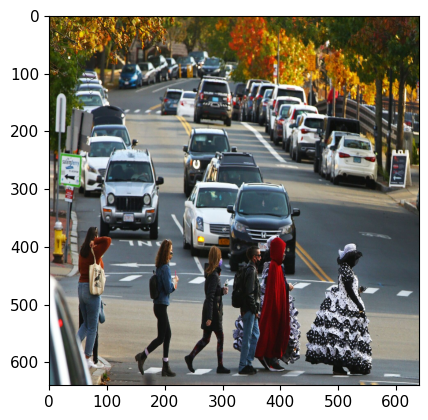

In [383]:
import cv2
from utils.general import non_max_suppression
from utils.plots import plot_images, output_to_target

img = cv2.imread('test_image_pedestrian.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (640,640), interpolation = cv2.INTER_CUBIC)
img = img/255.0
plt.figure()
plt.imshow(img)

In [384]:
img_tensor = torch.tensor(img).permute(2,0,1).unsqueeze(0).float()
img_tensor = img_tensor.to('cuda')
out, features = model_lowRate(img_tensor, active_scales = 5, return_layer=26)
out = out[0]
out = non_max_suppression(out, conf_thres=0.25, iou_thres=0.5, multi_label=True)


In [385]:
img_plotted = plot_images(img_tensor, output_to_target([out[0].detach().cpu()]))

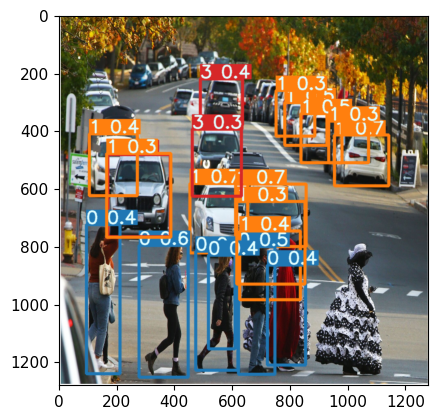

In [386]:
plt.figure()
plt.imshow(img_plotted)

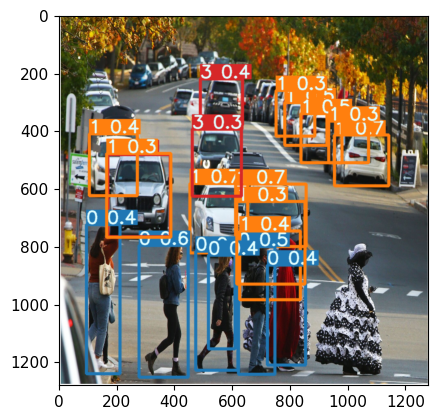

In [410]:
new_model_enc = new_model_enc.eval()
new_model_dec_lowRate = new_model_dec_lowRate.eval()
new_model_enc = new_model_enc.to('cuda')
new_model_dec_lowRate = new_model_dec_lowRate.to('cuda')
img_tensor = torch.tensor(img).permute(2,0,1).unsqueeze(0).float()
img_tensor = img_tensor.to('cuda')
features_2, features_ = new_model_enc(img_tensor, active_scales = 5, return_layer=8)
out, features_17 = new_model_dec_lowRate(features_2, return_layer=17)
out, features_14 = new_model_dec_lowRate(features_2, return_layer=14)
out, features_11 = new_model_dec_lowRate(features_2, return_layer=11)
new_model_dec_lowRate.model[-1].load_state_dict(model_lowRate.model[-1].state_dict())
new_model_dec_lowRate.model[-1].stride = model_lowRate.model[-1].stride
out = new_model_dec_lowRate.model[-1]([features_11, features_14, features_17])
out = out[0]
out = non_max_suppression(out, conf_thres=0.25, iou_thres=0.5, multi_label=True)
img_plotted = plot_images(img_tensor, output_to_target([out[0].detach().cpu()]))
plt.figure()
plt.imshow(img_plotted)

In [419]:
print(new_model_dec_lowRate.model[-1].stride)
print(model_lowRate.model[-1].stride)

tensor([0.50000, 1.00000, 2.00000])
tensor([ 8., 16., 32.])


In [390]:
for y, y2 in zip(features, features_):
    print(torch.mean((y-y2)**2))

tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)


In [391]:
print(torch.mean((features[0]-features_[0])**2))

tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)


In [345]:
for param0, param1 in zip(model_lowRate.model[-1].parameters(), new_model_dec_lowRate.model[-1].parameters()):
    if torch.sum(param0 != param1) > 0:
        print(i, '--------------')
        print(param0.shape)

In [136]:
new_model_enc.model[6].CONV[1].bias == model_lowRate.model[6].CONV[1].bias
# new_model_enc.model[6].CONV[0].weight == model_lowRate.model[6].CONV[0].weight

tensor([True], device='cuda:0')

In [81]:
for name, param in new_model_enc.model[8].named_parameters():
    if param.requires_grad:
        print(name)

CONV.0.conv.weight
CONV.0.bn.weight
CONV.0.bn.bias
CONV.1.conv.weight
CONV.1.bn.weight
CONV.1.bn.bias
CONV.2.conv.weight
CONV.2.bn.weight
CONV.2.bn.bias
CONV.3.conv.weight
CONV.3.bn.weight
CONV.3.bn.bias
CONV.4.conv.weight
CONV.4.bn.weight
CONV.4.bn.bias
CONV.5.conv.weight
CONV.5.bn.weight
CONV.5.bn.bias
CONV.6.conv.weight
CONV.6.bn.weight
CONV.6.bn.bias
CONV.7.conv.weight
CONV.7.bn.weight
CONV.7.bn.bias
CONV.8.weight
CONV.8.bias
CONV.9.weight
CONV.9.bias
CONV.10.weight
CONV.10.bias
BN.0.weight
BN.0.bias
BN.1.weight
BN.1.bias
BN.2.weight
BN.2.bias
BN.3.weight
BN.3.bias
BN.4.weight
BN.4.bias
BN.5.weight
BN.5.bias
BN.6.weight
BN.6.bias
BN.7.weight
BN.7.bias
BN.8.weight
BN.8.bias
BN.9.weight
BN.9.bias
BN.10.weight
BN.10.bias


In [340]:
for param in zip(new_model_dec_lowRate.model[-1].parameters(), new_model_dec_lowRate.model[-1].parameters()):
    if param0

Detect(
  (m): ModuleList(
    (0): Conv2d(128, 42, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(256, 42, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(512, 42, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [3]:
load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Single_decoder_fixYOLO/MSEInit_c8S2mix2_L1248/weights/best.pt', map_location=torch.device('cpu'))
mo_ = load['model']
model_lowRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/yolo_direct_c8S2mix2full_comp.yaml', nc = 9)
model_lowRate.load_state_dict(mo_)
model_lowRate = model_lowRate.to(device)
model_lowRate.eval();

load = torch.load('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Single_decoder_fixYOLO/MSEInit_c8S2mix2_L1248/weights/best.pt', map_location=torch.device('cpu'))
mo_ = load['model']
model_highRate = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/yolo_direct_c8S2mix2full_comp.yaml', nc = 9)
model_highRate.load_state_dict(mo_)
model_highRate = model_highRate.to(device)
model_highRate.eval();

new_model = Model('models/custom_models/Scalable/Linear_Comb/RCLWN_model/SingleDecoder/yolo_direct_c1S2x8c2x4full_comp.yaml', nc = 9)
weight_transfer_order = [0,1,2,3,4,5,None,None,None,9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
for to_id, from_id in enumerate(weight_transfer_order):
    if from_id is None:
        continue
    new_model.model[to_id].load_state_dict(model_lowRate.model[from_id].state_dict())
    print('Layer {} loaded from pretrained layer {}'.format(to_id, from_id))

Layer 0 loaded from pretrained layer 0
Layer 1 loaded from pretrained layer 1
Layer 2 loaded from pretrained layer 2
Layer 3 loaded from pretrained layer 3
Layer 4 loaded from pretrained layer 4
Layer 5 loaded from pretrained layer 5
Layer 9 loaded from pretrained layer 9
Layer 10 loaded from pretrained layer 10
Layer 11 loaded from pretrained layer 11
Layer 12 loaded from pretrained layer 12
Layer 13 loaded from pretrained layer 13
Layer 14 loaded from pretrained layer 14
Layer 15 loaded from pretrained layer 15
Layer 16 loaded from pretrained layer 16
Layer 17 loaded from pretrained layer 17
Layer 18 loaded from pretrained layer 18
Layer 19 loaded from pretrained layer 19
Layer 20 loaded from pretrained layer 20
Layer 21 loaded from pretrained layer 21
Layer 22 loaded from pretrained layer 22
Layer 23 loaded from pretrained layer 23
Layer 24 loaded from pretrained layer 24
Layer 25 loaded from pretrained layer 25
Layer 26 loaded from pretrained layer 26
Layer 27 loaded from pretraine

In [4]:
for i in range(8):
    new_model.model[6].CONV[i].weight = torch.nn.Parameter(model_lowRate.model[6].CONV[0].weight[i:i+1,:,:,:])
    new_model.model[6].CONV[i].bias = torch.nn.Parameter(model_lowRate.model[6].CONV[0].bias[i:i+1])
    new_model.model[6].BN[i].weight = torch.nn.Parameter(model_lowRate.model[6].BN[0].weight[i:i+1])
    new_model.model[6].BN[i].bias = torch.nn.Parameter(model_lowRate.model[6].BN[0].bias[i:i+1])
    
for i in range(4):
    new_model.model[6].CONV[i+8].weight = torch.nn.Parameter(model_lowRate.model[6].CONV[1].weight[2*i:2*i+2,:,:,:])
    new_model.model[6].CONV[i+8].bias = torch.nn.Parameter(model_lowRate.model[6].CONV[1].bias[2*i:2*i+2])
    new_model.model[6].BN[i+8].weight = torch.nn.Parameter(model_lowRate.model[6].BN[1].weight[2*i:2*i+2])
    new_model.model[6].BN[i+8].bias = torch.nn.Parameter(model_lowRate.model[6].BN[1].bias[2*i:2*i+2])

for i in range(8):
    new_model.model[8].CONV[i].conv.weight = torch.nn.Parameter(model_lowRate.model[8].CONV[0].conv.weight[i:i+1,:,:,:])
    new_model.model[8].CONV[i].bn.weight = torch.nn.Parameter(model_lowRate.model[8].CONV[0].bn.weight)
    new_model.model[8].CONV[i].bn.bias = torch.nn.Parameter(model_lowRate.model[8].CONV[0].bn.bias)
    new_model.model[8].BN[i].weight = torch.nn.Parameter(model_lowRate.model[8].BN[0].weight)
    new_model.model[8].BN[i].bias = torch.nn.Parameter(model_lowRate.model[8].BN[0].bias)

for i in range(4):
    new_model.model[8].CONV[i+8].weight = torch.nn.Parameter(model_lowRate.model[8].CONV[1].weight[:,2*i:2*i+2,:,:])
    new_model.model[8].CONV[i+8].bias = torch.nn.Parameter(model_lowRate.model[8].CONV[1].bias)
    new_model.model[8].BN[i+8].weight = torch.nn.Parameter(model_lowRate.model[8].BN[1].weight)
    new_model.model[8].BN[i+8].bias = torch.nn.Parameter(model_lowRate.model[8].BN[1].bias)
    
for i in range(2):
    new_model.model[6].CONV[i+12].load_state_dict(model_highRate.model[6].CONV[i+2].state_dict())
    new_model.model[6].BN[i+12].load_state_dict(model_highRate.model[6].BN[i+2].state_dict())
    new_model.model[7].Comp[i+12].load_state_dict(model_highRate.model[7].Comp[i+2].state_dict())
    new_model.model[8].CONV[i+12].load_state_dict(model_highRate.model[8].CONV[i+2].state_dict())
    new_model.model[8].BN[i+12].load_state_dict(model_highRate.model[8].BN[i+2].state_dict())

In [5]:
ckpt = {'model': new_model.state_dict()}

os.makedirs('runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Single_decoder_fixYOLO/EncDec_initFromc8S2mix2full_c1S2x8c2x4/weights', exist_ok = True)
torch.save(ckpt, 'runs/Scalable_COCOTraffic/Linear_Comb/RCLWN_model/Single_decoder_fixYOLO/EncDec_initFromc8S2mix2full_c1S2x8c2x4/weights/model_weights_combined.pt')